In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet169

from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import optimizers
from collections import Counter
import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D

In [3]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR')
]

In [4]:
def Train_Val_Plot2(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,recall,val_recall,prc,val_prc):
    
    fig, (ax1, ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(recall) + 1), recall)
    ax5.plot(range(1, len(val_recall) + 1), val_auc)
    ax5.set_title('History of recall')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('recall')
    ax5.legend(['training', 'validation'])
    
    ax6.plot(range(1, len(prc) + 1), prc)
    ax6.plot(range(1, len(val_prc) + 1), val_prc)
    ax6.set_title('History of prc')
    ax6.set_xlabel('Epochs')
    ax6.set_ylabel('prc')
    ax6.legend(['training', 'validation'])
    
    recall,val_recall,prc,val_prc
    
#     ax5.plot(range(1, len(f1) + 1), f1)
#     ax5.plot(range(1, len(val_f1) + 1), val_f1)
#     ax5.set_title('History of F1-score')
#     ax5.set_xlabel('Epochs')
#     ax5.set_ylabel('F1 score')
#     ax5.legend(['training', 'validation'])


    plt.show()

In [5]:
def initDataGens():
    
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   rotation_range=0.3, #5,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   #zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode='nearest')

#     valid_datagen = ImageDataGenerator(rescale = 1./255,
#                                   validation_split = 0.2
#                                   )

    test_datagen  = ImageDataGenerator(rescale = 1./255)


    return train_datagen, test_datagen, test_datagen

In [6]:
def initDataSets(train, test, train_datagen, valid_datagen, test_datagen, classes_):
    
    train_dataset  = train_datagen.flow_from_directory(directory = train,#'../input/fer2013/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   classes=classes_,
                                                   subset = 'training',
                                                   batch_size = 64)

    valid_dataset = train_datagen.flow_from_directory(directory = train,#'../input/fer2013/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  classes=classes_,
                                                  subset = 'validation',
                                                  batch_size = 64)
    
#     valid_dataset = valid_datagen.flow_from_directory(directory = train,#'../input/fer2013/train',
#                                                   target_size = (48,48),
#                                                   class_mode = 'categorical',
#                                                   classes=classes_,
#                                                   subset = 'validation',
#                                                   batch_size = 64)

    test_dataset = test_datagen.flow_from_directory(directory = test, #'../input/fer2013/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  classes=classes_,
                                                  batch_size = 64)


    return train_dataset, valid_dataset, test_dataset

In [7]:
def updateBaseModel(base_model, num_classes):
    
    for layer in base_model.layers[:]:
        layer.trainable=True
    
    # Building Model
    model=Sequential()
    model.add(base_model)
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(32,kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32,kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32,kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [8]:
def plot_DG(data_generator):
    counter = Counter(data_generator.classes)
    data_items = counter.items() # dict_items([(0, 1648), (1, 3614)])
    l = list(counter.items())
    print(l)
#     pd.DataFrame(l, columns=['class','count']).set_index('class').plot(kind='bar', colormap='Set2');
    
    plt.bar(range(len(l)), [val[1] for val in l], align='center')
    plt.xticks(range(len(l)), [val[0] for val in l])
    plt.xticks(rotation=70)
    plt.show()
    
#     df = pd.DataFrame(l, columns=['index', 'observers'])
#     print(df)
# ['Anger', 'Disgust', 'Fear', 'Happy','Neutral','Sad', 'Surprise']

In [9]:
def getClassWeights(train_dataset):
    
    counter = Counter(train_dataset.classes)                          
    max_val = float(max(counter.values()))       
    class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}    
    print(class_weights)

    return class_weights

In [10]:
def plotModel(model):
    
    plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
    Image(filename='convnet.png')

In [11]:
def getAllForTraining(model, save_h5_to_path, epochs_):
    
    lrd = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1,
    )

    mcp_5categories = ModelCheckpoint(save_h5_to_path)

    # es = EarlyStopping(verbose=1, patience=20)
    es = EarlyStopping(
        monitor='val_accuracy',
        min_delta=0.00005,
        patience=11,
        verbose=1,
        restore_best_weights=True,
    )

    # optimizers.Adam(learning_rate=1e-3, decay=1e-3 / epochs)
    # model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)
    t_epochs = epochs_

    optim = optimizers.Adam(learning_rate=1e-3, decay=1e-3 / t_epochs)
    model.compile(optimizer=optim, loss='categorical_crossentropy',metrics=METRICS)
    model.summary()

    return lrd, mcp_5categories, es, t_epochs, model, t_epochs


In [12]:
def plotConfusionMatrix(model, test_dataset, num_of_test_samples, batch_size, target_names):
    
    #Confution Matrix and Classification Report
    Y_pred = model.predict(test_dataset, num_of_test_samples // batch_size+1)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    cm = confusion_matrix(test_dataset.classes, y_pred)
    print('Classification Report')
    print(classification_report(test_dataset.classes, y_pred, target_names=target_names))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# Init for Deep Learning

Found 18603 images belonging to 7 classes.
Found 4648 images belonging to 7 classes.
Found 5772 images belonging to 7 classes.
{0: 1.0184766214177978, 1: 1.0025983667409057, 2: 1.0089652596189764, 3: 1.012368815592204, 4: 1.0, 5: 1.057556773688332, 6: 1.0165600301091458}
[(0, 2652), (1, 2694), (2, 2677), (3, 2668), (4, 2701), (5, 2554), (6, 2657)]


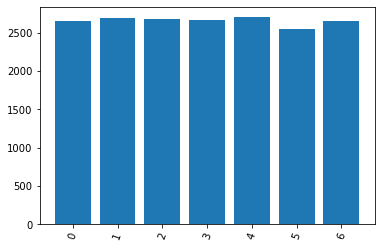

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 1, 1, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                32800     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               1

In [13]:
# 7 emotions

target_names = ['Anger','Disgust','Fear','Happy','Neutral','Sad','Surprise']
num_classes = len(target_names)
train_path = 'C:/Users/Asus/allCSVfILES/Emotion_Detection/train'
test_path = 'C:/Users/Asus/allCSVfILES/Emotion_Detection/test'
save_model_h5_to_path = 'C:/Users/Asus/allCSVfILES/Emotion_Detection/MobileNet-Classification-7emotions-CNN.h5'
epochs = 100

train_datagen, valid_datagen, test_datagen = initDataGens()
train_dataset, valid_dataset, test_dataset = initDataSets(train_path, test_path, train_datagen, valid_datagen, test_datagen, target_names)
class_weights = getClassWeights(train_dataset)
plot_DG(train_dataset)

# base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")
base_model = tf.keras.applications.MobileNet(input_shape=(48,48,3),include_top=False,weights="imagenet")

# model = build_net(optimizers.SGD(learning_rate=0.01, momentum=0.9), 7, METRICS)

model = updateBaseModel(base_model, len(target_names))
lrd, mcp_5categories, es, t_epochs, model, t_epochs = getAllForTraining(model, save_model_h5_to_path, epochs)

# Deep Learning

In [14]:
history1 = model.fit(train_dataset,validation_data=valid_dataset,epochs = t_epochs,verbose = 1,callbacks=[lrd,mcp_5categories,es], class_weight=class_weights)

Epoch 1/100
291/291 [==============================] - 172s 572ms/step - loss: 1.9427 - tp: 648.0000 - fp: 571.0000 - tn: 111047.0000 - fn: 17955.0000 - accuracy: 0.8577 - precision: 0.5316 - recall: 0.0348 - auc: 0.6017 - prc: 0.2226 - val_loss: 1.6327 - val_tp: 728.0000 - val_fp: 322.0000 - val_tn: 27566.0000 - val_fn: 3920.0000 - val_accuracy: 0.8696 - val_precision: 0.6933 - val_recall: 0.1566 - val_auc: 0.7558 - val_prc: 0.3973 - lr: 0.0010
Epoch 2/100
291/291 [==============================] - 171s 589ms/step - loss: 1.6233 - tp: 2484.0000 - fp: 875.0000 - tn: 110743.0000 - fn: 16119.0000 - accuracy: 0.8695 - precision: 0.7395 - recall: 0.1335 - auc: 0.7652 - prc: 0.4072 - val_loss: 1.5180 - val_tp: 1310.0000 - val_fp: 670.0000 - val_tn: 27218.0000 - val_fn: 3338.0000 - val_accuracy: 0.8768 - val_precision: 0.6616 - val_recall: 0.2818 - val_auc: 0.8053 - val_prc: 0.4858 - lr: 0.0010
Epoch 3/100
291/291 [==============================] - 170s 583ms/step - loss: 1.4416 - tp: 3744.0

291/291 [==============================] - 187s 643ms/step - loss: 0.9436 - tp: 10427.0000 - fp: 2679.0000 - tn: 108939.0000 - fn: 8176.0000 - accuracy: 0.9166 - precision: 0.7956 - recall: 0.5605 - auc: 0.9270 - prc: 0.7580 - val_loss: 0.7585 - val_tp: 3090.0000 - val_fp: 688.0000 - val_tn: 27200.0000 - val_fn: 1558.0000 - val_accuracy: 0.9310 - val_precision: 0.8179 - val_recall: 0.6648 - val_auc: 0.9504 - val_prc: 0.8179 - lr: 0.0010
Epoch 20/100
291/291 [==============================] - 209s 718ms/step - loss: 0.9259 - tp: 10730.0000 - fp: 2713.0000 - tn: 108905.0000 - fn: 7873.0000 - accuracy: 0.9187 - precision: 0.7982 - recall: 0.5768 - auc: 0.9292 - prc: 0.7670 - val_loss: 0.7200 - val_tp: 3275.0000 - val_fp: 752.0000 - val_tn: 27136.0000 - val_fn: 1373.0000 - val_accuracy: 0.9347 - val_precision: 0.8133 - val_recall: 0.7046 - val_auc: 0.9555 - val_prc: 0.8337 - lr: 0.0010
Epoch 21/100
291/291 [==============================] - 185s 636ms/step - loss: 0.9077 - tp: 10926.0000 -

291/291 [==============================] - ETA: 0s - loss: 0.7565 - tp: 12688.0000 - fp: 2587.0000 - tn: 109031.0000 - fn: 5915.0000 - accuracy: 0.9347 - precision: 0.8306 - recall: 0.6820 - auc: 0.9516 - prc: 0.8352
Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
291/291 [==============================] - 222s 764ms/step - loss: 0.7565 - tp: 12688.0000 - fp: 2587.0000 - tn: 109031.0000 - fn: 5915.0000 - accuracy: 0.9347 - precision: 0.8306 - recall: 0.6820 - auc: 0.9516 - prc: 0.8352 - val_loss: 0.6929 - val_tp: 3404.0000 - val_fp: 723.0000 - val_tn: 27165.0000 - val_fn: 1244.0000 - val_accuracy: 0.9395 - val_precision: 0.8248 - val_recall: 0.7324 - val_auc: 0.9575 - val_prc: 0.8477 - lr: 0.0010
Epoch 38/100
291/291 [==============================] - 199s 685ms/step - loss: 0.7072 - tp: 13183.0000 - fp: 2444.0000 - tn: 109174.0000 - fn: 5420.0000 - accuracy: 0.9396 - precision: 0.8436 - recall: 0.7086 - auc: 0.9570 - prc: 0.8523 - val_loss: 0.5592 - val_tp

291/291 [==============================] - 183s 629ms/step - loss: 0.5867 - tp: 14223.0000 - fp: 2183.0000 - tn: 109435.0000 - fn: 4380.0000 - accuracy: 0.9496 - precision: 0.8669 - recall: 0.7646 - auc: 0.9697 - prc: 0.8923 - val_loss: 0.5150 - val_tp: 3700.0000 - val_fp: 600.0000 - val_tn: 27288.0000 - val_fn: 948.0000 - val_accuracy: 0.9524 - val_precision: 0.8605 - val_recall: 0.7960 - val_auc: 0.9761 - val_prc: 0.9095 - lr: 5.0000e-04
Epoch 55/100
291/291 [==============================] - 184s 633ms/step - loss: 0.5733 - tp: 14356.0000 - fp: 2173.0000 - tn: 109445.0000 - fn: 4247.0000 - accuracy: 0.9507 - precision: 0.8685 - recall: 0.7717 - auc: 0.9710 - prc: 0.8964 - val_loss: 0.5446 - val_tp: 3675.0000 - val_fp: 630.0000 - val_tn: 27258.0000 - val_fn: 973.0000 - val_accuracy: 0.9507 - val_precision: 0.8537 - val_recall: 0.7907 - val_auc: 0.9729 - val_prc: 0.8985 - lr: 5.0000e-04
Epoch 56/100
291/291 [==============================] - 194s 667ms/step - loss: 0.5693 - tp: 14339.

291/291 [==============================] - 193s 662ms/step - loss: 0.4699 - tp: 15191.0000 - fp: 1874.0000 - tn: 109744.0000 - fn: 3412.0000 - accuracy: 0.9594 - precision: 0.8902 - recall: 0.8166 - auc: 0.9797 - prc: 0.9251 - val_loss: 0.5063 - val_tp: 3783.0000 - val_fp: 620.0000 - val_tn: 27268.0000 - val_fn: 865.0000 - val_accuracy: 0.9544 - val_precision: 0.8592 - val_recall: 0.8139 - val_auc: 0.9762 - val_prc: 0.9120 - lr: 2.5000e-04
Epoch 72/100
291/291 [==============================] - 188s 645ms/step - loss: 0.4780 - tp: 15185.0000 - fp: 1915.0000 - tn: 109703.0000 - fn: 3418.0000 - accuracy: 0.9590 - precision: 0.8880 - recall: 0.8163 - auc: 0.9791 - prc: 0.9231 - val_loss: 0.5353 - val_tp: 3759.0000 - val_fp: 674.0000 - val_tn: 27214.0000 - val_fn: 889.0000 - val_accuracy: 0.9520 - val_precision: 0.8480 - val_recall: 0.8087 - val_auc: 0.9743 - val_prc: 0.9044 - lr: 2.5000e-04
Epoch 73/100
291/291 [==============================] - 183s 628ms/step - loss: 0.4778 - tp: 15182.

In [33]:
def Train_Val_Plot3(acc,val_acc, auc,val_auc,precision,val_precision,recall,val_recall,prc,val_prc):
    
    fig, (ax1, ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


#     ax2.plot(range(1, len(loss) + 1), loss)
#     ax2.plot(range(1, len(val_loss) + 1), val_loss)
#     ax2.set_title('History of Loss')
#     ax2.set_xlabel('Epochs')
#     ax2.set_ylabel('Loss')
#     ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(recall) + 1), recall)
    ax5.plot(range(1, len(val_recall) + 1), val_auc)
    ax5.set_title('History of recall')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('recall')
    ax5.legend(['training', 'validation'])
    
    ax6.plot(range(1, len(prc) + 1), prc)
    ax6.plot(range(1, len(val_prc) + 1), val_prc)
    ax6.set_title('History of prc')
    ax6.set_xlabel('Epochs')
    ax6.set_ylabel('prc')
    ax6.legend(['training', 'validation'])
    
    recall,val_recall,prc,val_prc
    
#     ax5.plot(range(1, len(f1) + 1), f1)
#     ax5.plot(range(1, len(val_f1) + 1), val_f1)
#     ax5.set_title('History of F1-score')
#     ax5.set_xlabel('Epochs')
#     ax5.set_ylabel('F1 score')
#     ax5.legend(['training', 'validation'])


    plt.show()

# Statistics

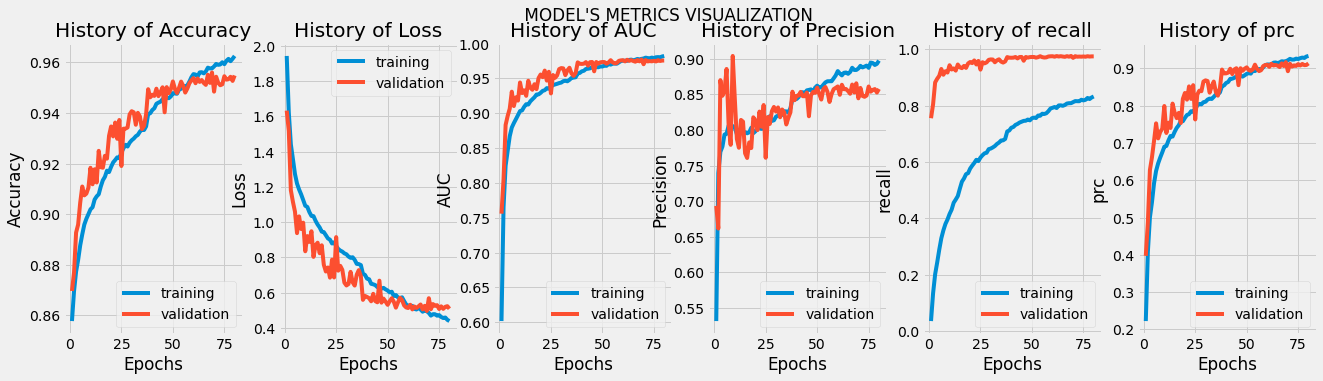

In [46]:
Train_Val_Plot2(history1.history['accuracy'],history1.history['val_accuracy'],
               history1.history['loss'],history1.history['val_loss'],
               history1.history['auc'],history1.history['val_auc'],
               history1.history['precision'],history1.history['val_precision'],
               history1.history['recall'],history1.history['val_recall'],
               history1.history['prc'],history1.history['val_prc']
              )

In [17]:
Train_Val_Plot2(history1.history['accuracy'],history1.history['val_accuracy']
              )

TypeError: Train_Val_Plot2() missing 10 required positional arguments: 'loss', 'val_loss', 'auc', 'val_auc', 'precision', 'val_precision', 'recall', 'val_recall', 'prc', and 'val_prc'

In [18]:
import pandas as pd  
import numpy as np
import time
from ast import literal_eval
from operator import add
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from sklearn.model_selection import StratifiedKFold
from collections import Counter
from sklearn.utils import resample
plt.style.use('fivethirtyeight')

from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import load_model
from sklearn.metrics import roc_curve, auc
from keras.callbacks import ModelCheckpoint


In [20]:
max_len = 40

loaded_our_model1 = load_model('C:/Users/Asus/allCSVfILES/Emotion_Detection/MobileNet-Classification-7emotions-CNN.h5')
print('Our model loaded')

Our model loaded


In [21]:
yhat_our1 = loaded_our_model1.predict(test_dataset)
print('our model complete!')

91/91 [==============================] - 11s 110ms/step
our model complete!


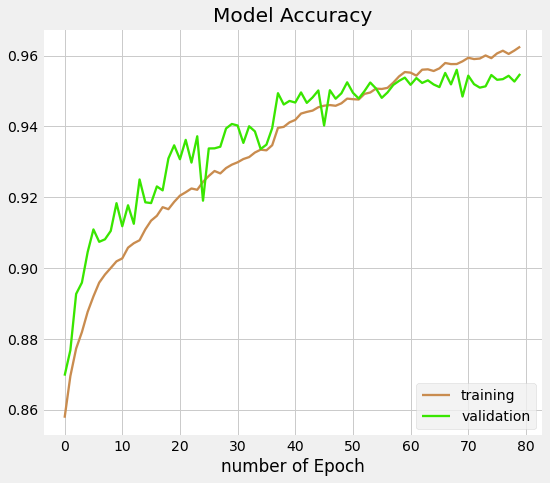

In [38]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_facecolor('white')


ax.plot(history1.history['accuracy'], label="training",linewidth=2.3, color = '#c98c4f')
if history1.history['val_accuracy'] is not None:
    ax.plot(history1.history['val_accuracy'], label="validation",linewidth=2.3, color = '#39e600')
ax.set_title('Model Accuracy')
ax.set_xlabel('number of Epoch')
ax.legend(loc='lower right')

# ax.plot(history1.history['accuracy'], label="training",linewidth=2.3)
# if my_df.accuracy is not None:
#     ax.plot(history1.history['val_accuracy'], label="validation",linewidth=2.3)
# ax.set_title('Model Accuracy')
# ax.set_xlabel('number of Epoch')
# ax.legend(loc='lower right')

# ax.set_ylim(bottom=0.5)
# ax.set_ylim(top=1.01)
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

plt.savefig('our_model_result1.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.1)

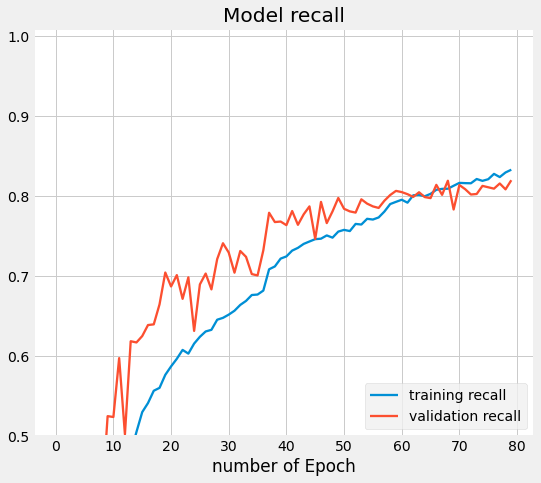

In [42]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_facecolor('white')


# ax.plot(history1.history['accuracy'], label="training",linewidth=2.3, color = '#c98c4f')
# if history1.history['val_accuracy'] is not None:
#     ax.plot(history1.history['val_accuracy'], label="validation",linewidth=2.3, color = '#39e600')
# ax.set_title('Model Accuracy')
# ax.set_xlabel('number of Epoch')
# ax.legend(loc='lower right')

ax.plot(history1.history['recall'], label="training recall",linewidth=2.3)
if history1.history['recall'] is not None:
    ax.plot(history1.history['val_recall'], label="validation recall",linewidth=2.3)
ax.set_title('Model recall')
ax.set_xlabel('number of Epoch')
ax.legend(loc='lower right')

ax.set_ylim(bottom=0.5)
ax.set_ylim(top=1.01)
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

plt.savefig('our_model_result5.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.1)

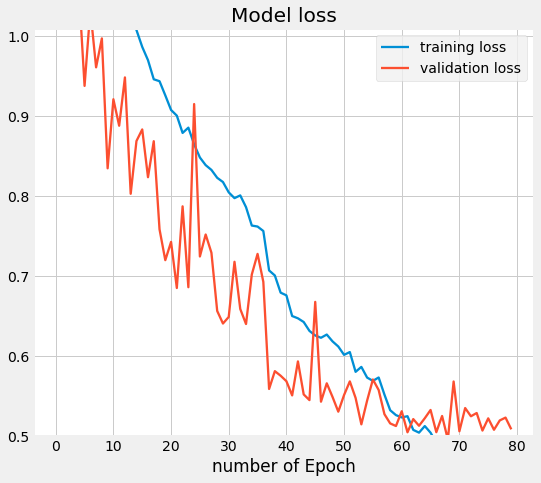

In [45]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_facecolor('white')


# ax.plot(history1.history['accuracy'], label="training",linewidth=2.3, color = '#c98c4f')
# if history1.history['val_accuracy'] is not None:
#     ax.plot(history1.history['val_accuracy'], label="validation",linewidth=2.3, color = '#39e600')
# ax.set_title('Model Accuracy')
# ax.set_xlabel('number of Epoch')
# ax.legend(loc='lower right')

ax.plot(history1.history['loss'], label="training loss",linewidth=2.3)
if history1.history['loss'] is not None:
    ax.plot(history1.history['val_loss'], label="validation loss",linewidth=2.3)
ax.set_title('Model loss')
ax.set_xlabel('number of Epoch')
ax.legend(loc='upper right')

ax.set_ylim(bottom=0.5)
ax.set_ylim(top=1.01)
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

plt.savefig('our_model_result6loss.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.1)